Setup and Imports

In [26]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
import sqlite3
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv

# Load API Key
load_dotenv()
API_KEY = os.getenv("OPENWEATHER_API_KEY")
LAT, LON = "11.0168", "76.9558" # Coimbatore
DB_PATH = "esg_history.db"

print(f"Environment Ready. Database Path: {os.path.abspath(DB_PATH)}")

Environment Ready. Database Path: C:\Users\abish\case study\Climate Impact & ESG Dashboard\esg_history.db


Database and Logic Functions

In [28]:
def init_db():
    with sqlite3.connect(DB_PATH) as conn:
        conn.execute("""
            CREATE TABLE IF NOT EXISTS esg_logs (
                timestamp TEXT, 
                distance REAL, 
                fuel TEXT, 
                aqi INTEGER,
                temperature REAL, 
                wind_speed REAL, 
                carbon REAL,
                risk_score REAL, 
                decision TEXT
            )
        """)
    print("✅ Database Initialized.")

init_db()

✅ Database Initialized.


Interactive Dashboard (The UI)

In [29]:
import random

def calculate_risk(distance, fuel, api_key):
    # Initialize default values for simulation
    aqi, temp, wind = 2, 25.0, 5.0 
    
    try:
        aqi_url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={LAT}&lon={LON}&appid={api_key}"
        w_url = f"https://api.openweathermap.org/data/2.5/weather?lat={LAT}&lon={LON}&appid={api_key}&units=metric"
        
        aqi_res = requests.get(aqi_url, timeout=5)
        w_res = requests.get(w_url, timeout=5)
        
        if aqi_res.status_code == 200 and w_res.status_code == 200:
            aqi = aqi_res.json()['list'][0]['main']['aqi']
            temp = w_res.json()['main']['temp']
            wind = w_res.json()['wind']['speed']
        else:
            print(f"⚠️ API Key Issue ({aqi_res.status_code}). Using Simulated data for this entry.")
            aqi = random.randint(1, 3)
            temp = random.uniform(20, 30)
            wind = random.uniform(2, 10)
    except Exception as e:
        print(f"⚠️ Connection Error. Using Simulated data.")

    # Business Logic
    factors = {"Diesel": 2.68, "Petrol": 2.31, "Electric": 0.5}
    carbon = round(distance * factors.get(fuel, 1.0), 2)
    
    # Calculate Risk Score
    c_norm = min(carbon/2000, 1)
    risk_score = round(((0.5 * c_norm) + (0.3 * (aqi-1)/4) + (0.2 * min(wind/20, 1))) * 100, 2)
    decision = "Delay Shipment" if risk_score > 60 else "Proceed"
    
    return {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "distance": distance, 
        "fuel": fuel, 
        "aqi": aqi,
        "temperature": temp, 
        "wind_speed": wind, 
        "carbon": carbon,
        "risk_score": risk_score, 
        "decision": decision
    }

Data Entry (The "Manual Seed")

In [30]:
print("--- ESG Shipment Input ---")
try:
    dist = float(input("Distance (km): ") or 5000)
    fuel = input("Fuel (Diesel/Petrol/Electric): ").strip().capitalize() or "Petrol"
    
    result = calculate_risk(dist, fuel, API_KEY)
    
    with sqlite3.connect(DB_PATH) as conn:
        pd.DataFrame([result]).to_sql("esg_logs", conn, if_exists="append", index=False)
    
    print(f"✅ DATA SAVED: Risk is {result['risk_score']}% ({result['decision']})")
except ValueError:
    print("❌ Error: Please enter a numeric value for distance.")

--- ESG Shipment Input ---


Distance (km):  50
Fuel (Diesel/Petrol/Electric):  Deisel


⚠️ API Key Issue (401). Using Simulated data for this entry.
✅ DATA SAVED: Risk is 23.36% (Proceed)


Analytics and Visualization

C:\Users\abish\AppData\Local\Temp\ipykernel_22748\2140781522.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='fuel', y='carbon', ax=ax2, palette='magma')
C:\Users\abish\anaconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\abish\anaconda3\Lib\site-packages\seaborn\categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns aft

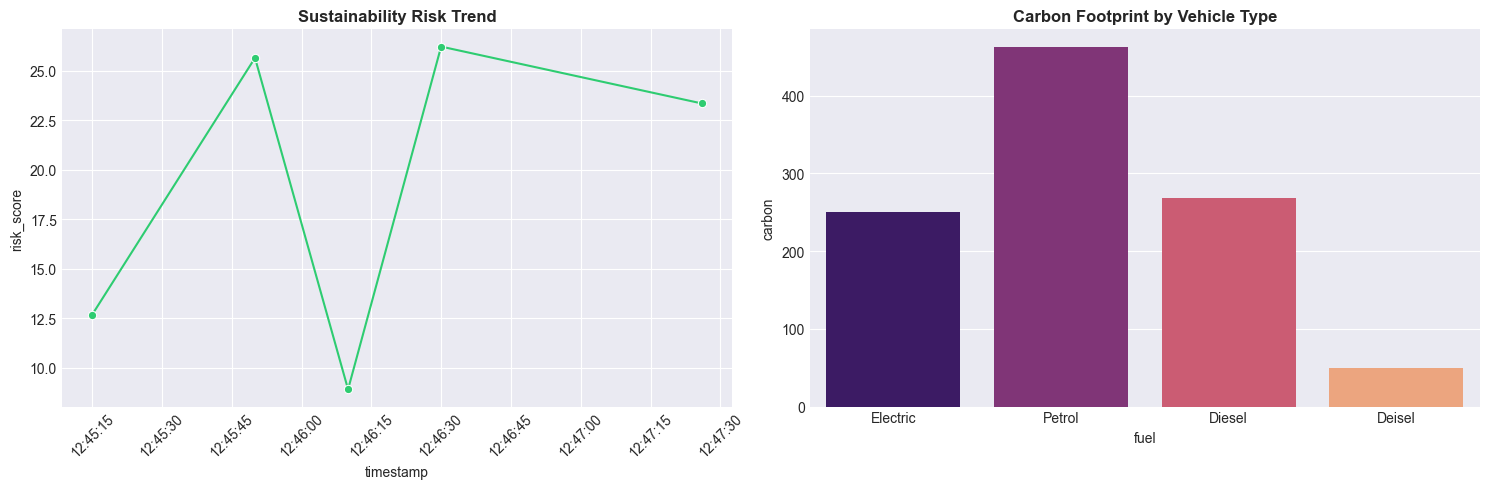

In [31]:
def show_dashboard():
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql("SELECT * FROM esg_logs", conn)
    
    if df.empty:
        print("⚠️ No data found. Run Cell 4 to add a shipment first!")
        return

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Trend Line
    sns.lineplot(data=df, x='timestamp', y='risk_score', marker='o', ax=ax1, color='#2ecc71')
    ax1.set_title("Sustainability Risk Trend", fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)

    # Comparison Bar
    sns.barplot(data=df, x='fuel', y='carbon', ax=ax2, palette='magma')
    ax2.set_title("Carbon Footprint by Vehicle Type", fontweight='bold')

    plt.tight_layout()
    plt.show()

show_dashboard()

In [32]:
with sqlite3.connect(DB_PATH) as conn:
    display_df = pd.read_sql("SELECT * FROM esg_logs ORDER BY timestamp DESC", conn)

display_df.head(10)

,timestamp,distance,fuel,aqi,temperature,wind_speed,carbon,risk_score,decision
0,2026-01-23 12:47:26,50.0,Deisel,3,25.040289,7.113818,50.0,23.36,Proceed
1,2026-01-23 12:46:30,100.0,Diesel,3,24.438662,4.525600,268.0,26.23,Proceed
2,2026-01-23 12:46:10,100.0,Diesel,1,24.941501,2.217200,268.0,8.92,Proceed
3,2026-01-23 12:45:50,200.0,Petrol,2,29.876217,6.613019,462.0,25.66,Proceed
4,2026-01-23 12:45:15,500.0,Electric,1,28.857899,6.436077,250.0,12.69,Proceed
